# Submission Group Assignment Network Science HS22

Participants:

    Alexander Christian Lerch, 17-678-111
    Diego Ricardo Bugmann, 18-472-548
    Szymon Kaczmarski, 21-743-778      

### LIBRARIES & DATASET

In [69]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import networkx.algorithms.community as nxcom
from matplotlib import colors as mcolors
import powerlaw
from scipy.special import factorial
import pandas as pd
from tabulate import tabulate
import time
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from tqdm import tqdm
import pickle

In [18]:
# -------------------P A T H S---------------------------
PATH_TWITCH_DE = 'dataset//DE//musae_DE_edges.csv'
PATH_TWITCH_EN = 'dataset//ENGB//musae_ENGB_edges.csv'
PATH_TWITCH_RU = 'dataset//RU//musae_RU_edges.csv'

# ----------------D A T A R E A D -----------------------
with open(PATH_TWITCH_DE, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_DE = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_EN, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_EN = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")
with open(PATH_TWITCH_RU, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_RU = nx.read_edgelist(twitch, delimiter=',', 
                                    create_using=nx.Graph(), 
                                    nodetype=int, encoding="utf-8")

# ---------------------S U M M A R Y ----------------------
print(PATH_TWITCH_DE, ' : ', G_TWITCH_DE)
print(PATH_TWITCH_EN, ' : ', G_TWITCH_EN)
print(PATH_TWITCH_RU, ' : ', G_TWITCH_RU)

dataset//DE//musae_DE_edges.csv  :  Graph with 9498 nodes and 153138 edges
dataset//ENGB//musae_ENGB_edges.csv  :  Graph with 7126 nodes and 35324 edges
dataset//RU//musae_RU_edges.csv  :  Graph with 4385 nodes and 37304 edges


In [19]:
PATH_TWITCH_FEATURES_DE = 'dataset//DE//musae_DE_target.csv'
PATH_TWITCH_FEATURES_EN = 'dataset//ENGB//musae_ENGB_target.csv'
PATH_TWITCH_FEATURES_RU = 'dataset//RU//musae_RU_target.csv'
df_features_de = pd.read_csv(PATH_TWITCH_FEATURES_DE, sep=',', header=0, index_col=0)
df_features_en = pd.read_csv(PATH_TWITCH_FEATURES_EN, sep=',', header=0, index_col=0)
df_features_ru = pd.read_csv(PATH_TWITCH_FEATURES_RU, sep=',', header=0, index_col=0)

# ALGORITHMS

In [72]:
ALGORITHMS_NAMES = ['Degree Centrality', 'K-Shell', 'Betweenness Centrality', 'VoteRank', 'PageRank', 'Closeness Centrality', 'Eigenvector Centrality', 'H-Index']

In [68]:
# --------------------- H - i n d e x ----------------------
# https://www.geeksforgeeks.org/what-is-h-index/
def h_index_for_node(G, n):
    # sorting in ascending order
    neighbour_degrees_sorted = sorted((G.degree(v) for v in G.neighbors(n))) 
    # iterating over the list
    for i, cited in enumerate(neighbour_degrees_sorted):
        # finding current result
        result = len(neighbour_degrees_sorted) - i
        # if result is less than or equal
        # to cited then return result
        if result <= cited:
            return result
    return 0

def h_index(G):
    hindex_list = {}
    for n in G.nodes():
        hindex_list[n] = H_index_for_node(G, n)
    return hindex_list

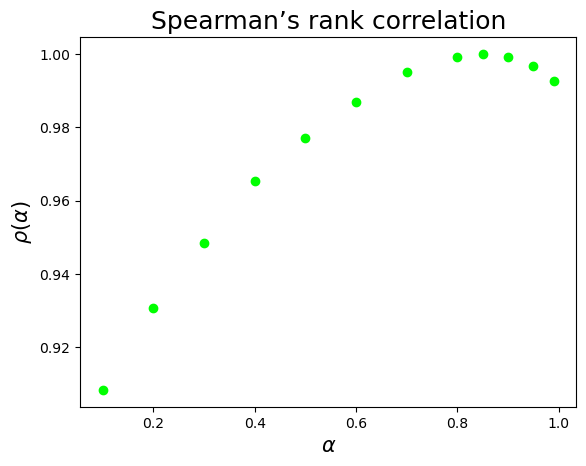

In [67]:
# Compute Spearman’s rank correlation 𝜌 between the PageRanks for 𝛼_0 = 0.85 and all other 𝛼_s
from scipy.stats import spearmanr
pr_alpha_0 = list(nx.pagerank(G_TWITCH_DE, alpha=0.85).values())
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]

# compute pagerank & spearman correlation for each alpha:
pageranks = {}
spearman_correlations = {}
for alpha in alpha_values:
    pageranks[alpha] = list(nx.pagerank(G_TWITCH_DE, alpha=alpha).values())
    spearman_correlations[alpha] = spearmanr(pr_alpha_0, pageranks[alpha])[0]

plt.scatter(spearman_correlations.keys(), spearman_correlations.values(), color = "lime")
plt.xlabel(r"$\alpha$", fontsize=15)
plt.ylabel(r"$\rho(\alpha)$", fontsize=15)
plt.title("Spearman’s rank correlation", size=18)
plt.show()

In [24]:
def run_algorithms(G):
    pbar = tqdm(total=len(ALGORITHMS_NAMES))
    results = []
    results.append(nx.degree_centrality(G)) # returns dict
    pbar.update(1)
    # k_shell - mark nodes in outer shell as 1, others as 0
    # outer_shell_nodes = list(nx.k_shell(G).nodes)
    # k_shell = [1 if node in outer_shell_nodes else 0 for node in G.nodes]
    core_number = nx.core_number(G) # returns dict
    results.append(core_number)
    pbar.update(1)
    results.append(nx.betweenness_centrality(G, k=None, normalized=True, weight=None, seed=123)) # returns dict
    pbar.update(1)
    results.append(nx.voterank(G, number_of_nodes=None)) # BUG Ordered list of computed seeds. Only nodes with positive number of votes are returned.
    # # create a dict with value for each node
    # dict_voterank = {}
    # max_value = len(G_TWITCH_EN.nodes)
    # i = 0
    # while i < len(result_voterank):
    #     dict_voterank[result_voterank[i]] = max_value
    #     max_value -= 1
    #     i += 1
    # # for all the nodes that are not in dict_voterank, set the value to 0
    # for n in G_TWITCH_EN.nodes:
    #     if n not in dict_voterank:
    #         dict_voterank[n] = 0
    pbar.update(1)
    results.append(nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-06, weight=None)) # returns dict
    pbar.update(1)
    results.append(nx.closeness_centrality(G)) # returns dict
    pbar.update(1)
    results.append(nx.eigenvector_centrality(G, max_iter=100, tol=1e-06)) # returns dict
    pbar.update(1)
    results.append(h_index(G)) # returns dict
    pbar.update(1)
    pbar.close()
    for i in range(len(results)):
        print('results[', i, '] length: ', len(results[i]))
        if len(results[i]) != len(G.nodes):
            print('ERROR - results[', i, '] is not the same length as G.nodes')
    return results

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


In [ ]:
# TESTME

results_de = run_algorithms(G_TWITCH_RU)

In [ ]:
# run for each language
results_de = run_algorithms(G_TWITCH_DE)
results_en = run_algorithms(G_TWITCH_EN)
results_ru = run_algorithms(G_TWITCH_RU)
# save the results in results folder as pickle
with open('results//results_de.pickle', 'wb') as handle:
    pickle.dump(results_de, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_en.pickle', 'wb') as handle:
    pickle.dump(results_en, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results//results_ru.pickle', 'wb') as handle:
    pickle.dump(results_ru, handle, protocol=pickle.HIGHEST_PROTOCOL)
# save names of algorithms
with open('results//algorithms_names.pickle', 'wb') as handle:
    pickle.dump(ALGORITHMS_NAMES, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load the results
with open('results//results_de.pickle', 'rb') as handle:
    results_de = pickle.load(handle)
with open('results//results_en.pickle', 'rb') as handle:
    results_en = pickle.load(handle)
with open('results//results_ru.pickle', 'rb') as handle:
    results_ru = pickle.load(handle)
# load names of algorithms
with open('results//algorithms_names.pickle', 'rb') as handle:
    ALGORITHMS_NAMES = pickle.load(handle)

# SIR (Susceptible-Infected-Recovered) model

In [87]:
# method to calculate the infected scale
def get_infected_scale(infected, recovered, total):
    return (infected + recovered) / total

# method to plot values
def plot_values(x, y, title):
    plt.plot(x, y)
    plt.ylabel("F(t)")
    plt.xlabel("t")
    plt.title(title)
    plt.show()

# method to get beta
def get_beta(network):
    beta_threshold = get_infection_threshold(network)
    return 1.5 * beta_threshold
    
# method to get the infection threshold
def get_infection_threshold(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    avg_sqrd_degrees = np.mean([d**2 for d in degrees])
    bth = avg_degree / (avg_sqrd_degrees - avg_degree)
    return bth

# method to get gamma
def get_gamma(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    return 2 / avg_degree

In [91]:
# method to simulate a model
def simulate(network, p, beta=None, gamma=None, num_of_simulations=100, num_of_t=200, show_bar=True):

    # ---------- Model Configuration ----------
    model = ep.SIRModel(network)
    n = network.number_of_nodes()
    
    # Beta and Gamma is chosen basen on explanation in paragraph 3.2
    beta = get_beta(network) if beta == None else beta
    gamma = get_gamma(network) if gamma == None else gamma
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
    cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
    cfg.add_model_parameter("fraction_infected", p)   # TODO REMOVE

    # -------------------------------------------------------
    # TODO : Selection of initial nodes based on algorithms
    # infected_nodes = []
    # cfg.add_model_initial_configuration("Infected", infected_nodes)
    # -------------------------------------------------------

    model.set_initial_status(cfg)


    # ---------- Simulation ----------
    
    # execute the simulations and save them in a list
    simulations = []
    for i in range(num_of_simulations):
        model.reset() # reset so that each simulation starts from scratch
        simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
        simulations.append(simulation)

    x = list(range(num_of_t))
    y = []

    # average out the infected / recovered for each step, calculate the infected_scale and save it to a list
    for i in range(num_of_t):
        infected = np.mean([simulation[i]['node_count'][1] for simulation in simulations]) # get the mean for each step
        recovered = np.mean([simulation[i]['node_count'][2] for simulation in simulations]) # get the mean for each step
        # calculate F(t) and add it to the y-values
        infected_scale_value = get_infected_scale(infected, recovered, n)
        y.append(infected_scale_value)
    
    print("Beta: "+str(beta))
    print("Gamma: "+str(gamma))
    
    return x, y


Beta: 0.025608421113680682
Gamma: 0.20173253312195674


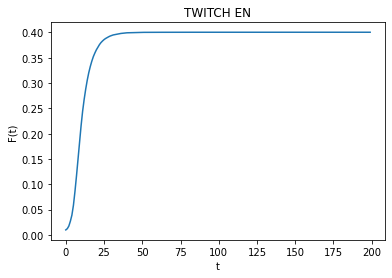

Beta: 0.005900017098483644
Gamma: 0.062022489519257144


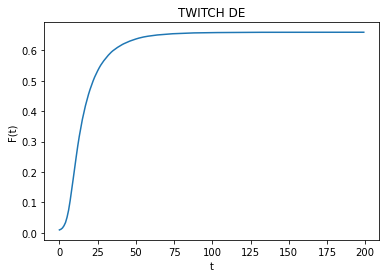

In [92]:
# ---------- Simulate & Plot the values (EN) ----------
x, y = simulate(G_TWITCH_EN, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH EN")

# ---------- Simulate & Plot the values (DE) ----------
x, y = simulate(G_TWITCH_DE, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH DE")


<k>: 27.696969696969695
bth = 0.026566678293221718
beta = 1.5 * bth = 0.039850017439832575
gamma = beta / lambda (1.25) = 0.03188001395186606
p = 0.02
Beta: 0.039850017439832575
Gamma: 0.03188001395186606


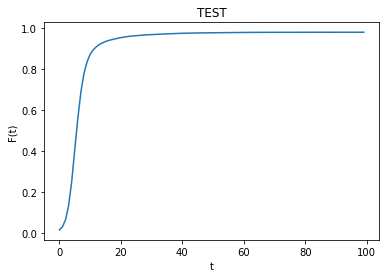

COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]


In [97]:
# -------------------- SECTION DIFFERENT DATASETS --------------------

# !!!!! uncomment the one you want to use and then run !!!!!

# ---------- FACEBOOK ----------
# G = nx.read_gml("dataset/graph_facebook.gml")


# ---------- JAZZ ----------
G = nx.read_gml("dataset/graph_jazz_collab.gml")


# ---------- DOLPHINS ----------
# G = nx.read_gml("dataset/graph_dolphins.gml")



# -------------------- Calculate some numbers in order to get the same parameters as in paper [2] --------------------
n = G.number_of_nodes()
degrees = [v for k,v in G.degree()]
avg_degree = np.mean(degrees)
avg_sqrd_degrees = np.mean([d**2 for d in degrees])

print("<k>: "+str(avg_degree))
bth = get_infection_threshold(G)                          # [2] PAGE 7 (formula for bth) / PAGE 10 table 4 (value for bth)
beta = 1.5 * bth                                          # [2] PAGE 7 (formula for beta)
lamb = 1.25                                               # [2] PAGE 11 figure 2 (ratio infection prob / recovery prob)
p = 0.02                                                  # [2] PAGE 11 figure 2
print("bth = "+str(bth))
print("beta = 1.5 * bth = "+str(beta))
gamma = beta / lamb                                       # [2] PAGE 7 (formula for beta)
print("gamma = beta / lambda (1.25) = "+str(gamma))       # [2] PAGE 11 figure 2: Use ratio of 1.25
print("p = "+str(p))


# ---------- Simulate ----------
x, y = simulate(G, p=p, beta=beta, gamma=gamma, num_of_simulations=100, num_of_t=100, show_bar=False)

# ---------- Plot the values ----------
plot_values(x, y, "TEST")
print("COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]")